In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
#detecting license plate on the vehicle
plateCascade = cv2.CascadeClassifier('indian_license_plate.xml')

In [3]:
#detect the plate and return car + plate image
def plate_detect(img):
    plateImg = img.copy()
    roi = img.copy()
    plateRect = plateCascade.detectMultiScale(plateImg,scaleFactor = 1.2, minNeighbors = 7)
    for (x,y,w,h) in plateRect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate_part = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plateImg,(x+2,y),(x+w-3, y+h-5),(0,255,0),3)
    return plateImg, plate_part

In [4]:
#normal function to display 
def display_img(img):
    img_ = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img_)
    plt.show()

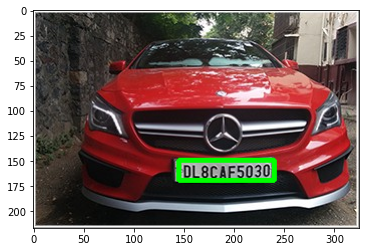

In [6]:
#test image is used for detecting plate
inputImg = cv2.imread('car.jpg')
inpImg, plate = plate_detect(inputImg)
display_img(inpImg)

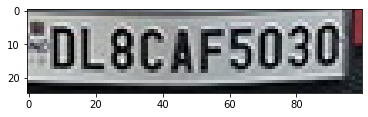

In [7]:
display_img(plate)


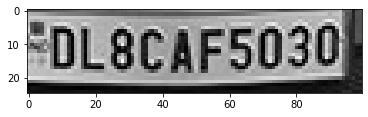

In [8]:
grey=cv2.cvtColor(plate,cv2.COLOR_BGR2GRAY)
display_img(grey)

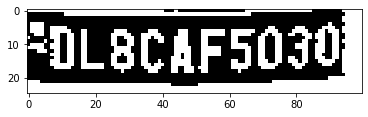

In [28]:
ret, bw_img = cv2.threshold(grey, 127, 255, cv2.THRESH_BINARY)
bw_img=255-bw_img
display_img(bw_img)

In [9]:
def find_contours(dimensions, img) :

    #finding all contours in the image using 
    #retrieval mode: RETR_TREE
    #contour approximation method: CHAIN_APPROX_SIMPLE
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #Approx dimensions of the contours
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    #Check largest 15 contours for license plate character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ci = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detecting contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 
            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            cv2.rectangle(ci, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ci, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    #return characters on ascending order with respect to the x-coordinate
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [11]:
def segment_characters(image) :

    #pre-processing cropped image of plate
    #threshold: convert to pure b&w with sharpe edges
    #erod: increasing the backgroung black
    #dilate: increasing the char white
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    #estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    #getting contours
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

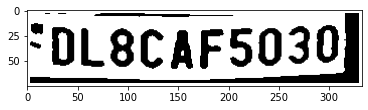

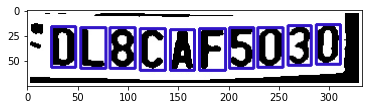

In [12]:
char = segment_characters(plate)

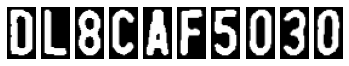

In [13]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [14]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data/data/'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  
        target_size=(28,28), 
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  
        target_size=(28,28),  
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [15]:
#It is the harmonic mean of precision and recall
#Output range is [0, 1]
#Works for both multi-class and multi-label classification
def f1score(y, y_pred):
    return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
    return tf.py_function(f1score, (y, y_pred), tf.double)

In [16]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=[custom_f1score])

In [17]:
class stop_training_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_custom_f1score') > 0.99):
            self.model.stop_training = True

In [20]:

batch_size = 1

history= model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 50)

Epoch 1/50
864/864 [==============================] - 59s 68ms/step - loss: 1.4542 - custom_f1score: 0.5868 - val_loss: 0.7490 - val_custom_f1score: 0.7842
Epoch 2/50
864/864 [==============================] - 62s 72ms/step - loss: 0.6855 - custom_f1score: 0.7778 - val_loss: 0.4581 - val_custom_f1score: 0.8304
Epoch 3/50
864/864 [==============================] - 66s 76ms/step - loss: 0.4386 - custom_f1score: 0.8611 - val_loss: 0.2608 - val_custom_f1score: 0.9241
Epoch 4/50
864/864 [==============================] - 75s 87ms/step - loss: 0.3393 - custom_f1score: 0.8935 - val_loss: 0.2724 - val_custom_f1score: 0.9196
Epoch 5/50
864/864 [==============================] - 65s 75ms/step - loss: 0.2843 - custom_f1score: 0.9109 - val_loss: 0.2237 - val_custom_f1score: 0.9509
Epoch 6/50
864/864 [==============================] - 64s 74ms/step - loss: 0.1995 - custom_f1score: 0.9340 - val_loss: 0.1948 - val_custom_f1score: 0.9211
Epoch 7/50
864/864 [==============================] - 62s 71ms/s

In [21]:
#model.save('ANPR_model_FINAL3.pkl')

INFO:tensorflow:Assets written to: ANPR_model_FINAL3.pkl\assets


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

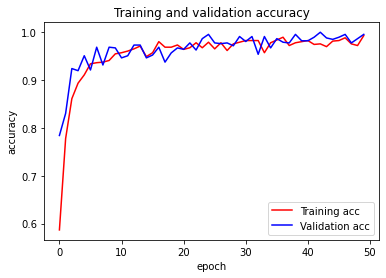

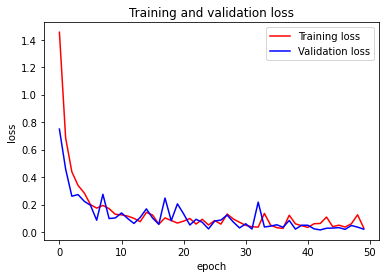

In [25]:
#Graphing our training and validation
accuracy = history.history['custom_f1score']
val_accuracy = history.history['val_custom_f1score']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [16]:
from keras.models import load_model
# Restore the weights
model.load_weights('ANPR_model_FINAL3.pkl')


In [26]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): 
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
       # predict_x=model.predict(img) 
        #classes_x=np.argmax(predict_x,axis=1)
        y_ = model.predict_classes(img)[0]
        character = dic[y_] #
        output.append(character) 
        
    plate_number = ''.join(output)
    
    return plate_number
    character = dic[predict_x]
    output.append(character) 
        
    plate_number = ''.join(output)
    
    return plate_number

final_plate = show_results()
print(final_plate)

C:\Users\joshi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


DL8CAF5030


In [ ]:
count = 0
videoFile = "License.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5)
x=1
while(cap.isOpened()):
    frameId = cap.get(1)
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="Vehicle_%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

In [ ]:
img = plt.imread('Vehicle_2.jpg') 
plt.imshow(img)

In [ ]:
int x=1
for i in range(0,count):
    frame="Vehicle_"+str(i)+".jpg"
    inpImg, plate = plate_detect(frame)
    char = segment_characters(plate)
    if(x==1):
        show_results()
        x=0